**Introduction**

This model predicts whether or not a person has pneumonia and if so, is it bacterial or viral pneumonia. This kernel is part of an end to end ml solution - starting with a model and ending with a app deployed in streamlit. A user is able to submit a chest x-ray and get an instant prediction. 

This Kaggle dataset was set up as a binary classification problem - pneumonia or no pneumonia. But we found that the images had file names containing normal, bacteria or virus so , extracted these and used them as target classes to create a 3 class classification problem - Normal, Viral, Bacterial.

This solution uses transfer learning applied to a MobileNet model. All training was done in this kernel. MobileNet was designed for the deployment . It is small (aprox. 35MB) and runs fast. 

# Importing the Necessary Libraries

In [1]:
from numpy.random import seed
seed(101)
import tensorflow as tf
tf.random.set_seed(101)

import pandas as pd
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

import os
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


### Check for the count of files in each folder
Note: In some folders there is a non image file called  '.DS_Store'

In [2]:
# Train
# normal
print(len(os.listdir('Data/chest_xray/train/NORMAL')))
# pneumonia
print(len(os.listdir('Data/chest_xray/train/PNEUMONIA')))


1342
3876


In [3]:
# Val
# normal
print(len(os.listdir('Data/chest_xray/val/NORMAL')))
# pneumonia
print(len(os.listdir('Data/chest_xray/val/PNEUMONIA')))

9
9


In [4]:
# Test
# normal
print(len(os.listdir('Data/chest_xray/test/NORMAL')))
# pneumonia
print(len(os.listdir('Data/chest_xray/test/PNEUMONIA')))

234
390


In [5]:
os.listdir('Data/chest_xray/test')

['.DS_Store', 'NORMAL', 'PNEUMONIA']

### Create a Dataframe containing all images

In [6]:
# create a list of files in each folder
train_normal_list = os.listdir('Data/chest_xray/train/NORMAL')
train_pneu_list = os.listdir('Data/chest_xray/train/PNEUMONIA')
val_normal_list = os.listdir('Data/chest_xray/val/NORMAL')
val_pneu_list = os.listdir('Data/chest_xray/val/PNEUMONIA')
test_normal_list = os.listdir('Data/chest_xray/test/NORMAL')
test_pneu_list = os.listdir('Data/chest_xray/test/PNEUMONIA')

In [7]:
def assign_pneu_type(x):
    x = str(x)
    if 'virus' in x:
        return 'viral'
    if 'bacteria' in x:
        return 'bacterial'

In [8]:
# TRAIN_NORMAL
# create the dataframe
df_train_normal = pd.DataFrame(train_normal_list, columns=['image_id'])
# delete the entry named .DS_Store
df_train_normal = df_train_normal[df_train_normal['image_id'] != '.DS_Store']
# create a new target column
df_train_normal['target'] = 'normal'

# TRAIN_PNEU
# create the dataframe
df_train_pneu = pd.DataFrame(train_pneu_list, columns=['image_id'])
# delete the entry named .DS_Store
df_train_pneu = df_train_pneu[df_train_pneu['image_id'] != '.DS_Store']
# create a target column that's a copy of the image column
df_train_pneu['target'] = df_train_pneu['image_id']
# apply the function to this target column
df_train_pneu['target'] = df_train_pneu['target'].apply(assign_pneu_type)

# VAL_NORMAL
# create the dataframe
df_val_normal = pd.DataFrame(val_normal_list, columns=['image_id'])
# delete the entry named .DS_Store
df_val_normal = df_val_normal[df_val_normal['image_id'] != '.DS_Store']
# create a new target column
df_val_normal['target'] = 'normal'


# VAL_PNEU
# create the dataframe
df_val_pneu = pd.DataFrame(val_pneu_list, columns=['image_id'])
# delete the entry named .DS_Store
df_val_pneu = df_val_pneu[df_val_pneu['image_id'] != '.DS_Store']
# create a target column that's a copy of the image column
df_val_pneu['target'] = df_val_pneu['image_id']
# apply the function to this target column
df_val_pneu['target'] = df_val_pneu['target'].apply(assign_pneu_type)


# TEST_NORMAL
# create the dataframe
df_test_normal = pd.DataFrame(test_normal_list, columns=['image_id'])
# delete the entry named .DS_Store
df_test_normal = df_test_normal[df_test_normal['image_id'] != '.DS_Store']
# create a new target column
df_test_normal['target'] = 'normal'


# TEST_PNEU
# create the dataframe
df_test_pneu = pd.DataFrame(test_pneu_list, columns=['image_id'])
# delete the entry named .DS_Store
df_test_pneu = df_test_pneu[df_test_pneu['image_id'] != '.DS_Store']
# create a target column that's a copy of the image column
df_test_pneu['target'] = df_test_pneu['image_id']
# apply the function to this target column
df_test_pneu['target'] = df_test_pneu['target'].apply(assign_pneu_type)


In [9]:
# Concat the dataframes
df_data = \
pd.concat([df_train_normal,df_train_pneu,df_val_normal,df_val_pneu,df_test_normal,
           df_test_pneu],axis=0).reset_index(drop=True)

# shuffle
df_data = shuffle(df_data)

df_data.shape

(5856, 2)

In [10]:
# Check the target distribution
df_data['target'].value_counts()

bacterial    2780
normal       1583
viral        1493
Name: target, dtype: int64

In [11]:
df_data.head()

,image_id,target
2013,person1328_virus_2294.jpeg,viral
2596,person1582_bacteria_4136.jpeg,bacterial
109,IM-0285-0001.jpeg,normal
5156,person96_virus_179.jpeg,viral
1638,person1160_bacteria_3105.jpeg,bacterial


### Create the directory structure
The original dataset directory structure was set up to support a binary classification problem. Because we will be predicting 3 classes we need to change this structure. In these folders we will store the images that will later be fed to the Keras generators.

# New Directory

In [14]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 3 folders inside 'base_dir':

# train
    # normal
    # bacterial
    # viral

# val
    # normal
    # bacterial
    # viral


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
normal = os.path.join(train_dir, 'normal')
os.mkdir(normal)
bacterial = os.path.join(train_dir, 'bacterial')
os.mkdir(bacterial)
viral = os.path.join(train_dir, 'viral')
os.mkdir(viral)


# create new folders inside val_dir
normal = os.path.join(val_dir, 'normal')
os.mkdir(normal)
bacterial = os.path.join(val_dir, 'bacterial')
os.mkdir(bacterial)
viral = os.path.join(val_dir, 'viral')
os.mkdir(viral)


In [15]:
os.listdir('base_dir/train_dir')

['bacterial', 'normal', 'viral']

### Create Train and Val Sets

In [16]:
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(4977, 2)
(879, 2)


In [17]:
# check df_train class distribution
df_train['target'].value_counts()

bacterial    2363
normal       1345
viral        1269
Name: target, dtype: int64

In [18]:
# check df_val class distribution
df_val['target'].value_counts()

bacterial    417
normal       238
viral        224
Name: target, dtype: int64

### Transfer the Images into the Folders

In [19]:
df_data.head()

,image_id,target
2013,person1328_virus_2294.jpeg,viral
2596,person1582_bacteria_4136.jpeg,bacterial
109,IM-0285-0001.jpeg,normal
5156,person96_virus_179.jpeg,viral
1638,person1160_bacteria_3105.jpeg,bacterial


In [20]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [21]:
# Get a list of images in each of the folders
train_normal_list = os.listdir('Data/chest_xray/train/NORMAL')
train_pneu_list = os.listdir('Data/chest_xray/train/PNEUMONIA')
val_normal_list = os.listdir('Data/chest_xray/val/NORMAL')
val_pneu_list = os.listdir('Data/chest_xray/val/PNEUMONIA')
test_normal_list = os.listdir('Data/chest_xray/test/NORMAL')
test_pneu_list = os.listdir('Data/chest_xray/test/PNEUMONIA')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Transfer the train images

for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in train_normal_list:
        # source path to image
        src = os.path.join('Data/chest_xray/train/NORMAL', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in train_pneu_list:
        # source path to image
        src = os.path.join('Data/chest_xray/train/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in val_normal_list:
        # source path to image
        src = os.path.join('Data/chest_xray/val/NORMAL', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in val_pneu_list:
        # source path to image
        src = os.path.join('Data/chest_xray/val/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        
    if fname in test_normal_list:
        # source path to image
        src = os.path.join('Data/chest_xray/test/NORMAL', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in test_pneu_list:
        # source path to image
        src = os.path.join('Data/chest_xray/test/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        
        


# Transfer the val images

for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in train_normal_list:
        # source path to image
        src = os.path.join('Data/chest_xray/train/NORMAL', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in train_pneu_list:
        # source path to image
        src = os.path.join('Data/chest_xray/train/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in val_normal_list:
        # source path to image
        src = os.path.join('Data/chest_xray/val/NORMAL', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in val_pneu_list:
        # source path to image
        src = os.path.join('Data/chest_xray/val/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in test_normal_list:
        # source path to image
        src = os.path.join('Data/chest_xray/test/NORMAL', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in test_pneu_list:
        # source path to image
        src = os.path.join('Data/chest_xray/test/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        




In [22]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/normal')))
print(len(os.listdir('base_dir/train_dir/bacterial')))
print(len(os.listdir('base_dir/train_dir/viral')))

1345
2363
1269


In [23]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/normal')))
print(len(os.listdir('base_dir/val_dir/bacterial')))
print(len(os.listdir('base_dir/val_dir/viral')))

238
417
224


### Copy the train images into aug_dir
aug_dir is where we temporarily store images from a given class before feeding them into the generator for augmentation.¶ 

We will not be augmenting on the fly. We will create augmented images, store them in folders together with the raw images and then feed these into the generators. I found that working this way makes the training process run faster. 

In [24]:
class_list = ['normal','bacterial','viral']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'bacterial'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)
    
    
    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 5000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1345 images belonging to 1 classes.
Found 2363 images belonging to 1 classes.
Found 1269 images belonging to 1 classes.


In [25]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/normal')))
print(len(os.listdir('base_dir/train_dir/bacterial')))
print(len(os.listdir('base_dir/train_dir/viral')))

5035
4976
4957


In [26]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/normal')))
print(len(os.listdir('base_dir/val_dir/bacterial')))
print(len(os.listdir('base_dir/val_dir/viral')))

238
417
224


### Visualize 50 augmented images

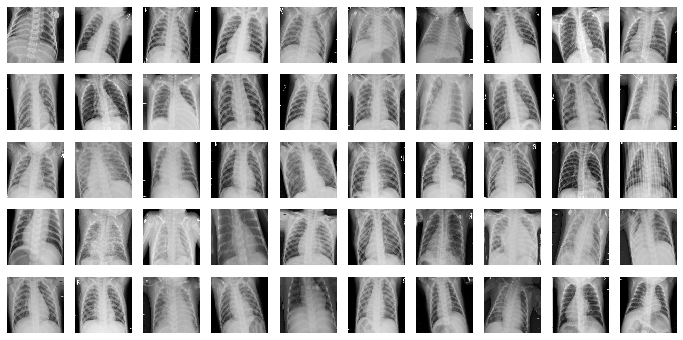

In [27]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

### Set Up the Generators

In [29]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [30]:
train_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    train_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=train_batch_size,
                                                    class_mode='categorical')
valid_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    valid_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=val_batch_size,
                                                    class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    valid_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=val_batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 14968 images belonging to 3 classes.
Found 879 images belonging to 3 classes.
Found 879 images belonging to 3 classes.


### Load MobileNet Model

In [31]:
# create a copy of a mobilenet model

mobile = keras.applications.mobilenet.MobileNet()

In [32]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [33]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(3, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [34]:
type(mobile.layers)

list

In [35]:
# How many layers does MobileNet have?
len(mobile.layers)

91

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

### Modifying the Model to get expected Shape in output

In [37]:
from keras.models import Model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D

# Remove the existing last layer
x = model.layers[-2].output

# Add new layers
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Define a new model
model = Model(inputs=model.input, outputs=predictions)


In [40]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [38]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 40 layers in the new model.
# The last 40 layers of the model will be trained.

for layer in model.layers[:-40]:
    layer.trainable = False

### Train the Model

In [39]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy])

C:\Users\MD.ARSHAD\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'bacterial': 0, 'normal': 1, 'viral': 2}


In [41]:
# Add weights to try to make the model more sensitive to a specific class

class_weights={
    0: 1.0, # bacterial
    1: 1.0, # normal
    2: 1.0, # viral
}

In [42]:
val_steps

88.0

In [43]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D


In [44]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

C:\Users\MD.ARSHAD\AppData\Local\Temp\ipykernel_13044\271271456.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_batches, steps_per_epoch=train_steps,


Epoch 1/10
498/498 [==============================] - ETA: 0s - loss: 0.7067 - categorical_accuracy: 0.7356
Epoch 1: val_categorical_accuracy improved from -inf to 0.73948, saving model to model.h5
498/498 [==============================] - 147s 290ms/step - loss: 0.7067 - categorical_accuracy: 0.7356 - val_loss: 0.7707 - val_categorical_accuracy: 0.7395 - lr: 0.0010
Epoch 2/10
498/498 [==============================] - ETA: 0s - loss: 0.5041 - categorical_accuracy: 0.7930
Epoch 2: val_categorical_accuracy improved from 0.73948 to 0.80319, saving model to model.h5
498/498 [==============================] - 139s 279ms/step - loss: 0.5041 - categorical_accuracy: 0.7930 - val_loss: 0.4405 - val_categorical_accuracy: 0.8032 - lr: 0.0010
Epoch 3/10
498/498 [==============================] - ETA: 0s - loss: 0.4218 - categorical_accuracy: 0.8263
Epoch 3: val_categorical_accuracy improved from 0.80319 to 0.82025, saving model to model.h5
498/498 [==============================] - 136s 274ms/st

# Saving the model

In [45]:
model.save('model.h5')

### Evaluate the model using the val set¶

In [46]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy']

In [47]:
# Here the the last epoch will be used.

val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

C:\Users\MD.ARSHAD\AppData\Local\Temp\ipykernel_13044\3842142301.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_batches,


val_loss: 0.4154127240180969
val_cat_acc: 0.852104663848877


In [49]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

C:\Users\MD.ARSHAD\AppData\Local\Temp\ipykernel_13044\3733077460.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_batches,


val_loss: 0.4154127240180969
val_cat_acc: 0.852104663848877


### Plot the Training Curves

<Figure size 432x288 with 0 Axes>

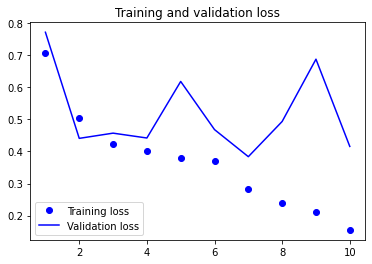

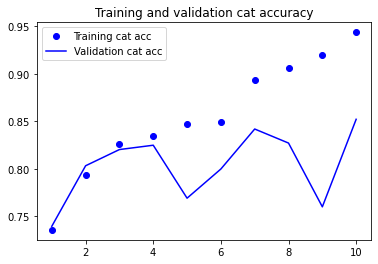

<Figure size 432x288 with 0 Axes>

In [50]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

### Create a Confusion Matrix

In [51]:
# Get the labels of the test images.
# Note that cats and dogs are in seperate folders therefore
# the code below can get the labels depending on the folder the image is in.

test_labels = test_batches.classes

In [52]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [53]:
# Print the label associated with each class
test_batches.class_indices

{'bacterial': 0, 'normal': 1, 'viral': 2}

In [54]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=val_steps, verbose=1)

C:\Users\MD.ARSHAD\AppData\Local\Temp\ipykernel_13044\3012817285.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_batches, steps=val_steps, verbose=1)


88/88 [==============================] - 36s 388ms/step


In [55]:
predictions.shape

(879, 3)

In [56]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [57]:
test_labels.shape

(879,)

In [58]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [59]:
test_batches.class_indices

{'bacterial': 0, 'normal': 1, 'viral': 2}

Confusion matrix, without normalization
[[350   6  61]
 [  0 231   7]
 [ 50   6 168]]


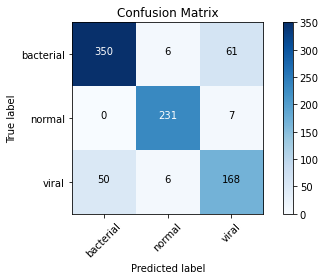

In [60]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['bacterial', 'normal', 'viral']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Create a Classification Report

In [61]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_batches.filenames

# Get the true labels
y_true = test_batches.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [62]:
from sklearn.metrics import classification_report

# Generate a classification report


report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

   bacterial       0.88      0.84      0.86       417
      normal       0.95      0.97      0.96       238
       viral       0.71      0.75      0.73       224

    accuracy                           0.85       879
   macro avg       0.85      0.85      0.85       879
weighted avg       0.85      0.85      0.85       879



# Let's Make some Predictions

### Load the Model

In [1]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

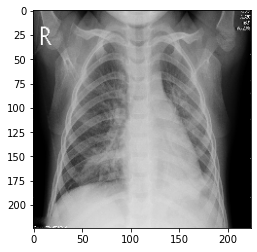

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#make prediction for the image at a specific location
img = cv2.imread('Data/chest_xray/test/PNEUMONIA/person1644_virus_2844.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to RGB format
img = cv2.resize(img, (224, 224)) # resize to match the input size of the model
img = img / 255.0 # normalize the pixel values

# Display the image
plt.imshow(img)
plt.show()

In [5]:
class_names = ['Bacterial', 'Normal', 'Viral'] # List of class names in the order of the model's output
pred = model.predict(np.array([img]))[0] # make a prediction on the image and get the probabilities

for i, class_name in enumerate(class_names):
    class_perc = pred[i] * 100 # get the percentage of prediction for the class
    print(f"{class_name}: {class_perc:.2f}%")

1/1 [==============================] - 1s 928ms/step
Bacterial: 0.31%
Normal: 0.06%
Viral: 99.63%


### from the above we can see that the xray indicates Viral pneumonia 

### Thus using the Model we can Predict whether a Person has Viral Pneumonia , Bacterial Pneumonia or Normal hence we can Deploy the model in Streamlit